<a href="https://colab.research.google.com/github/m4xig1/ProfileDenoiser/blob/main/denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Как я уже говорил, опыта работы со звуком у меня никакого, мои познания (до написания ноутбука) заканчиваются на знании о том, что существует преобразование Фурье, с помощью которой можно представить волну в виде линейной комбинации синусов и косинусов

#Denoiser


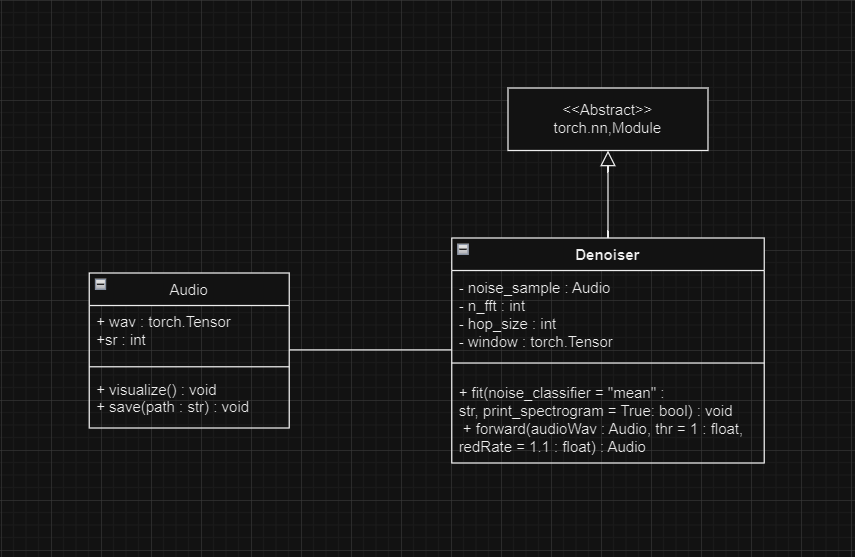

Хотелось бы иметь структуру, которая будет хранить аудио и рисовать нужные графики при необходимости, для этого нужен класс `Audio`. Конечно, дизайн кода оставляет желать лучшего, но для такого небольшого проекта сойдет. Для того, чтобы использовать файл как библиотеку, можно подключить файл из директории `data/denoiser.py`. Коллаб работает через одно место с файлами, но по идее в локальном jupiter ноутбуке все должно рабоать (сейчас у меня не все библиотеки установлены на машине, так что проверить я это, к сожалению, не смогу). Также в папке `data` можно найти файлы, с которыми я тестировал деноизер.

In [ ]:
# uncomment b4 restarting kernell
# !pip install torch -U
# !pip install torchaudio -U  # ?))
# !pip install pyloudnorm

In [ ]:
#!g1.1
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# from scipy.io import wavfile
from IPython import display
import soundfile as sf
# import pyloudnorm as pyln
from copy import copy, deepcopy


In [ ]:
class Audio():
    def __init__(self, path : str):
        # self.wav, self.sr = torchaudio.load(path)
        self.wav, self.sr = sf.read(path)
        self.wav = torch.Tensor(self.wav)
        if self.wav.ndim == 2:
            self.wav = self.wav.mean(1)

    def visualize(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.wav, alpha=.7, c='green')
        plt.grid()
        plt.xlabel('Time', size=20)
        plt.ylabel('Amplitude', size=20)
        plt.show()
        display.display(display.Audio(self.wav, rate=self.sr))

    def save(self, path : str):
        sf.write(path, self.wav, self.sr)


# denoiser сохраняет параметры STFT
class Denoiser(torch.nn.Module):
    def __init__(self, noise_sample, n_fft = 1024, hop_size = 256, window = torch.hann_window(1024), **kwargs):
        super().__init__()

        self.__noise_sample = noise_sample
        self.__profile = torch.Tensor()
        self.__n_fft = n_fft
        self.__window_size = n_fft
        self.__hop_size = hop_size
        self.__window = window


    def forward(self, audioWav : Audio, thr = 1, redRate = 1.1) -> Audio: # убирает шум из audioWav используя профиль
        assert (self.__profile.nelement() != 0), "Fit model with fit() before denoising audio"

        spectrum = torch.stft(audioWav.wav,
                              n_fft=self.__n_fft,
                              win_length=self.__window_size,
                              hop_length=self.__hop_size,
                              window=self.__window,
                              return_complex=True)

        spectrogram = abs(spectrum)

        spectrum *= (1 - thr * self.__profile[None, :].T / (spectrogram + 1e-12))  # reshape profile to [freq, 1]
        spectrum /= redRate

        denoised = audioWav
        denoised.wav = torch.istft(spectrum,
                              n_fft=self.__n_fft,
                              win_length=self.__window_size,
                              hop_length=self.__hop_size,
                              window=self.__window)

        return denoised


    def fit(self, noise_classifier ="mean", print_spectrogram = True): # оценивает уровень шума в noize_sample
        spectrum = torch.stft(self.__noise_sample.wav,
                              n_fft=self.__n_fft,
                              win_length=self.__window_size,
                              hop_length=self.__hop_size,
                              window=self.__window,
                              return_complex=True)

        spectrogram = spectrum.abs()
        """
        Кажется, есть несколько способов, которые можно попробовать для определения амплитуды шума:
        т.к. спектрограмма у шума выглядит достаточно просто (при формулировании задачи как в условии),
        то можно попробовать использовать mean, median.
        """
        if noise_classifier == "mean":
            self.__profile = spectrogram.mean(dim=-1)
        elif noise_classifier == "median":
            self.__profile, _ = torch.median(spectrogram, dim=-1)
        else:
            raise Exception("Bad input classifier")

        print(self.__profile.shape)
        if print_spectrogram:
            plt.figure(figsize=(20, 5))
            plt.imshow(spectrogram.squeeze().log())
            plt.xlabel('Time', size=20)
            plt.ylabel('Frequency (Hz)', size=20)
            plt.show()

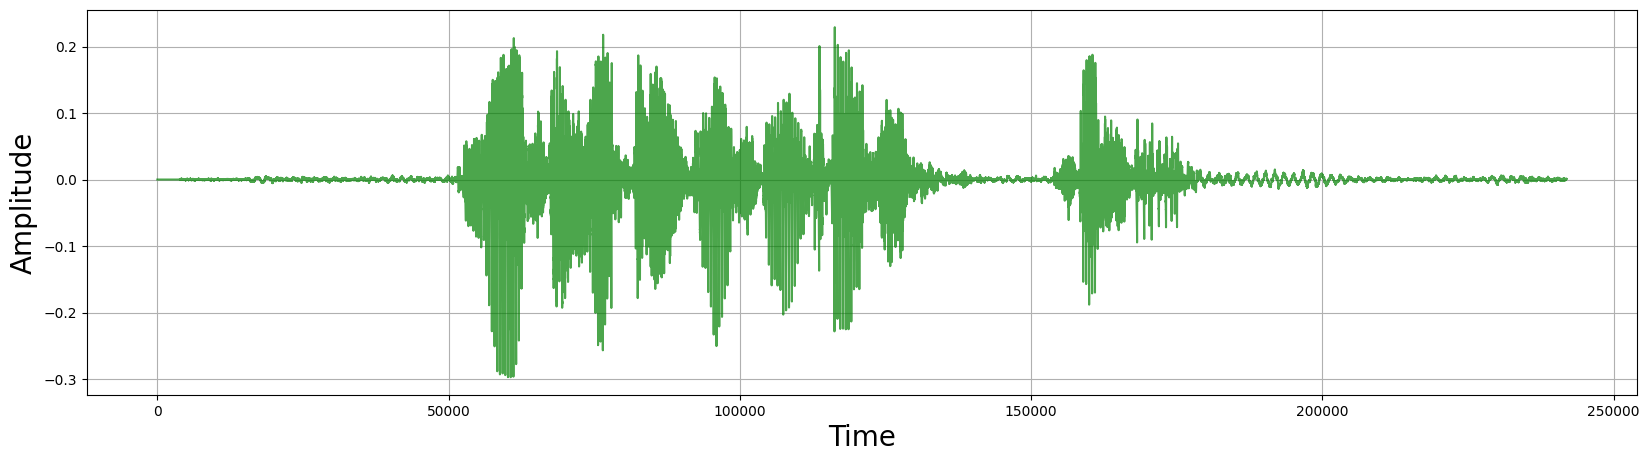

In [ ]:
noise_sample = Audio('nonoise.wav')
voice_sample = Audio('voice.wav')
# noise_sample.visualize()
voice_sample.visualize()

torch.Size([513])


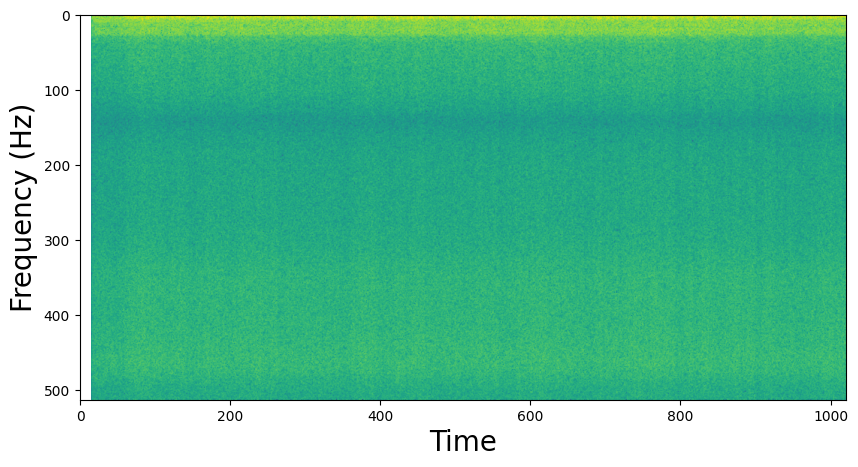

In [ ]:
dnsr = Denoiser(noise_sample)
dnsr.fit(noise_classifier='mean')

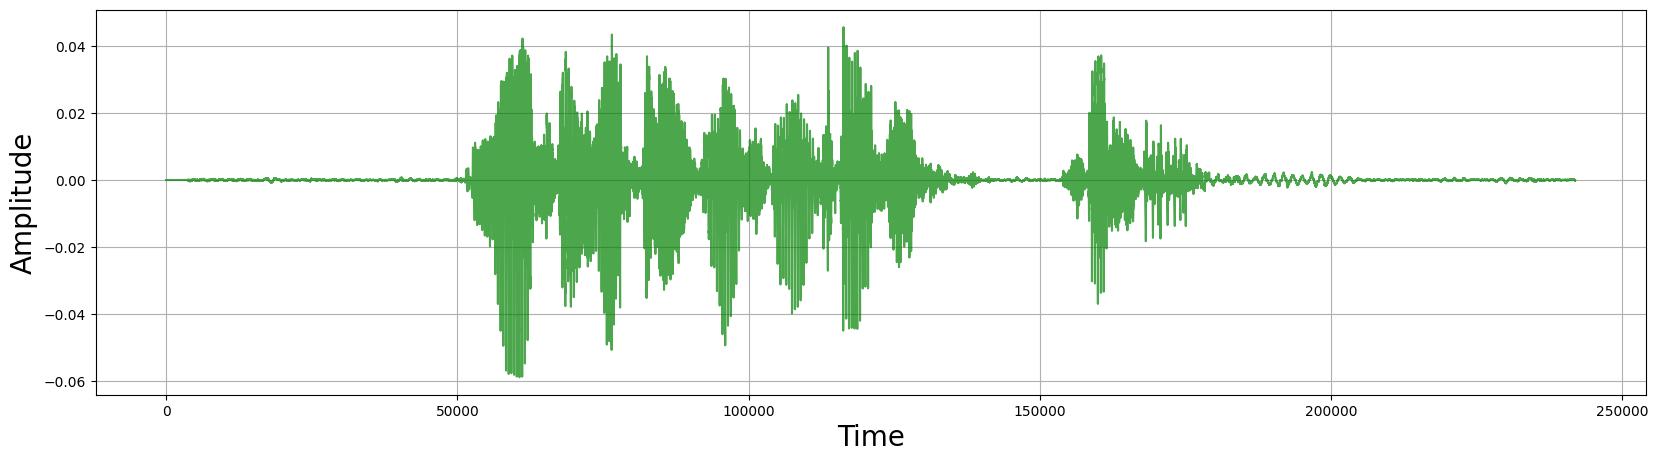

In [ ]:
ans = dnsr.forward(voice_sample, thr=1, redRate=5)
ans.visualize()
ans.save("ans.wav")

Отличия в сигнале есть: в начале и в конце он стал более гладкий (в этих местах был шум).

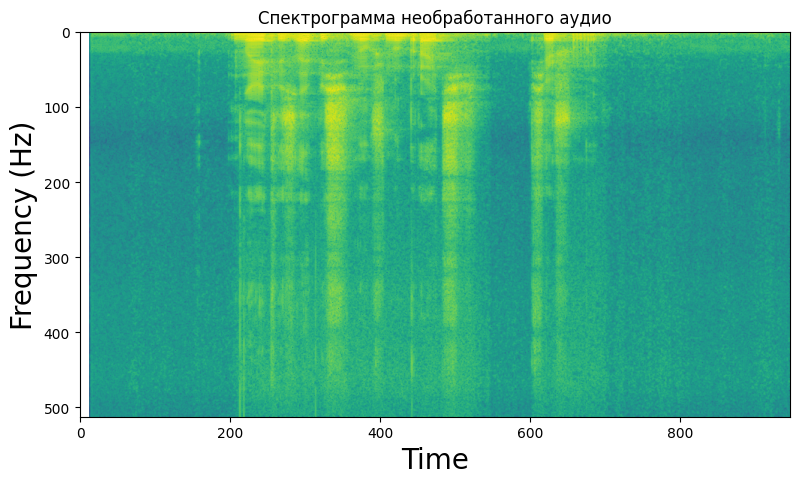

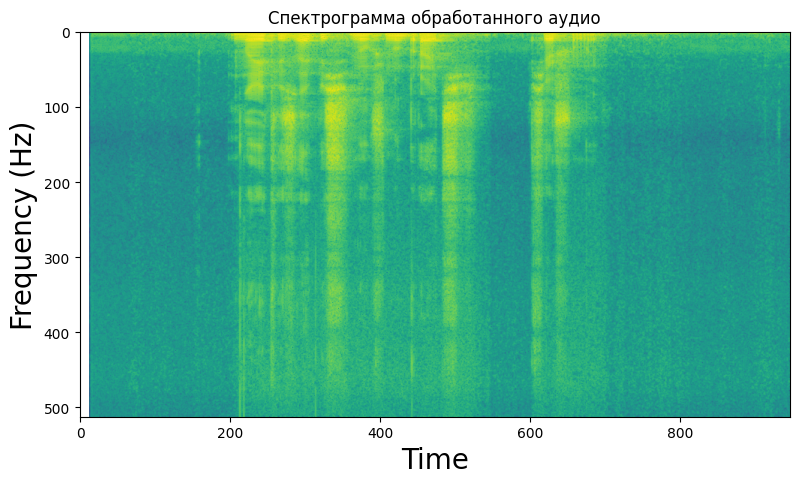

In [ ]:
spectrogram = torch.stft(voice_sample.wav,
                        n_fft=1024,
                        win_length=1024,
                        hop_length=256,
                        window=torch.hann_window(1024),
                        return_complex=True).abs()

plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.title("Спектрограмма необработанного аудио")
plt.show()

spectrogram1 = torch.stft(ans.wav,
                        n_fft=1024,
                        win_length=1024,
                        hop_length=256,
                        window=torch.hann_window(1024),
                        return_complex=True).abs()

plt.figure(figsize=(20, 5))
plt.imshow(spectrogram1.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.title("Спектрограмма обработанного аудио")
plt.show()

Визуально мало можно что сказать, но видно, что места, характеризующие звук, стали более яркими по сравнению с шумом.